In [6]:
import os
import cv2
import numpy as np
import mediapipe as mp
import pandas as pd

In [13]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5)

In [21]:
def load_fer2013_data(base_path):
    categories = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    data = []
    
    for category in categories:
        # Define the path to the images for each emotion
        path = os.path.join(base_path, category)
        class_num = categories.index(category)  # This will be the label

        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_array = cv2.resize(img_array, (48, 48))  # Resize if needed
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)

    return pd.DataFrame(data, columns=['image', 'label'])


In [22]:
train_data = load_fer2013_data("../../Dataset/FER2013/train")
test_data = load_fer2013_data("../../Dataset/FER2013/test")

In [11]:
def get_facial_landmarks(image, image_width, image_height):
    # Convert the image color from BGR to RGB as MediaPipe expects RGB images
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Initialize MediaPipe Face Mesh
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5) as face_mesh:
        # Process the image and get the face landmarks
        results = face_mesh.process(image_rgb)

        if results.multi_face_landmarks:
            landmarks = results.multi_face_landmarks[0].landmark
            spatial_landmarks = np.zeros((image_height, image_width, 3), dtype=np.float32)

            for landmark in landmarks:
                x, y = int(landmark.x * (image_width - 1)), int(landmark.y * (image_height - 1))
                
                # Clip x and y to ensure they are within the array bounds
                x = min(x, image_width - 1)
                y = min(y, image_height - 1)

                spatial_landmarks[y, x, :] = [landmark.x, landmark.y, landmark.z]

            return spatial_landmarks
        else:
            return None


In [23]:
def landmarks_to_heatmap(landmarks, image_size=(48, 48)):
    heatmap = np.zeros((image_size[0], image_size[1]), dtype=np.float32)  # Initialize an empty image

    for x, y, _ in landmarks:
        x_norm = int(x * (image_size[0] - 1))
        y_norm = int(y * (image_size[1] - 1))

        # Define the size of the area affected by each landmark
        radius = 3  # You can adjust the radius

        # Increase intensity around the landmark
        for i in range(-radius, radius + 1):
            for j in range(-radius, radius + 1):
                if 0 <= x_norm + i < image_size[0] and 0 <= y_norm + j < image_size[1]:
                    # Decrease intensity with distance from the landmark
                    distance = np.sqrt(i**2 + j**2)
                    intensity = max(0, 1 - distance / radius)
                    heatmap[y_norm + j, x_norm + i] = max(heatmap[y_norm + j, x_norm + i], intensity)

    # Normalize the heatmap
    heatmap /= np.max(heatmap)

    return heatmap

In [10]:
def extract_landmarks_from_dataset(dataset):
    all_landmarks = []
    for index, row in dataset.iterrows():
        image = row['image']
        landmarks = get_facial_landmarks(image, 48, 48)
        
        # Check if landmarks array is not empty
        if landmarks is not None and landmarks.any():
            all_landmarks.append(landmarks)
        else:
            print(f"No landmarks detected for image at index {index}")

    return all_landmarks


In [24]:
train_data

,image,label
0,"[[50, 32, 15, 11, 12, 10, 10, 8, 15, 10, 7, 7,...",0
1,"[[29, 24, 29, 11, 15, 22, 26, 11, 7, 17, 29, 2...",0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
3,"[[155, 138, 98, 112, 94, 97, 111, 107, 101, 84...",0
4,"[[211, 215, 220, 221, 219, 216, 213, 210, 207,...",0
...,...,...
28704,"[[27, 26, 26, 26, 27, 27, 28, 28, 33, 34, 35, ...",6
28705,"[[7, 6, 13, 39, 76, 58, 29, 21, 16, 20, 34, 56...",6
28706,"[[124, 129, 125, 123, 129, 128, 127, 128, 131,...",6
28707,"[[242, 242, 242, 216, 110, 42, 20, 41, 37, 14,...",6


In [25]:
train_landmarks = extract_landmarks_from_dataset(train_data)

No landmarks detected for image at index 2
No landmarks detected for image at index 11
No landmarks detected for image at index 25
No landmarks detected for image at index 27
No landmarks detected for image at index 35
No landmarks detected for image at index 54
No landmarks detected for image at index 79
No landmarks detected for image at index 81
No landmarks detected for image at index 85
No landmarks detected for image at index 91
No landmarks detected for image at index 103
No landmarks detected for image at index 121
No landmarks detected for image at index 128
No landmarks detected for image at index 132
No landmarks detected for image at index 141
No landmarks detected for image at index 142
No landmarks detected for image at index 144
No landmarks detected for image at index 152
No landmarks detected for image at index 182
No landmarks detected for image at index 190
No landmarks detected for image at index 195
No landmarks detected for image at index 207
No landmarks detected

In [27]:
train_landmarks

[array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], dtype=float32),
 array([[[0., 0., 0.],
         [0., 0.,

In [17]:
# Original dataset size
original_size = len(train_data)

# Size after landmark extraction
landmark_extracted_size = len(train_landmarks)

# Comparing the sizes
print(f"Original Dataset Size: {original_size}")
print(f"Landmark Extracted Dataset Size: {landmark_extracted_size}")

# Calculate the number of images with no detected landmarks
no_landmarks_count = original_size - landmark_extracted_size
print(f"Number of images with no detected landmarks: {no_landmarks_count}")


Original Dataset Size: 24612
Landmark Extracted Dataset Size: 22857
Number of images with no detected landmarks: 1755


In [18]:
# Assuming train_landmarks is your processed data
print("Shape of the data:", np.array(train_landmarks).shape)

Shape of the data: (22857, 48, 48, 3)


In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)),  # Adjust the input shape as needed
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.5),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.6),

    Flatten(),
    Dense(1024, activation='relu'),
    Dense(7, activation='softmax')  # Assuming 7 emotion classes
])

optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Assuming the labels are in the same order as the images
train_labels = train_data['label'][train_data.index.isin([index for index, _ in enumerate(train_landmarks)])].to_numpy()

In [19]:
train_landmarks

[array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], dtype=float32),
 array([[[0., 0., 0.],
         [0., 0.,

In [66]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)

In [73]:
from sklearn.model_selection import train_test_split

# Split your data
X_train, X_val, y_train, y_val = train_test_split(np.array(train_landmarks), train_labels, test_size=0.3, random_state=42)

# Train the model
history = model.fit(X_train, y_train, epochs=90, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])


Epoch 1/90
500/500 [==============================] - 24s 44ms/step - loss: 1.6392 - accuracy: 0.3078 - val_loss: 1.6669 - val_accuracy: 0.3206
Epoch 2/90
500/500 [==============================] - 21s 41ms/step - loss: 1.6050 - accuracy: 0.3285 - val_loss: 1.6073 - val_accuracy: 0.3847
Epoch 3/90
500/500 [==============================] - 23s 46ms/step - loss: 1.5597 - accuracy: 0.3625 - val_loss: 1.5365 - val_accuracy: 0.3984
Epoch 4/90
500/500 [==============================] - 26s 53ms/step - loss: 1.5269 - accuracy: 0.3776 - val_loss: 1.5090 - val_accuracy: 0.3903
Epoch 5/90
500/500 [==============================] - 22s 45ms/step - loss: 1.5014 - accuracy: 0.3897 - val_loss: 1.4895 - val_accuracy: 0.4111
Epoch 6/90
500/500 [==============================] - 22s 45ms/step - loss: 1.4897 - accuracy: 0.3950 - val_loss: 1.4624 - val_accuracy: 0.4160
Epoch 7/90
500/500 [==============================] - 23s 46ms/step - loss: 1.4669 - accuracy: 0.4052 - val_loss: 1.4451 - val_accuracy:

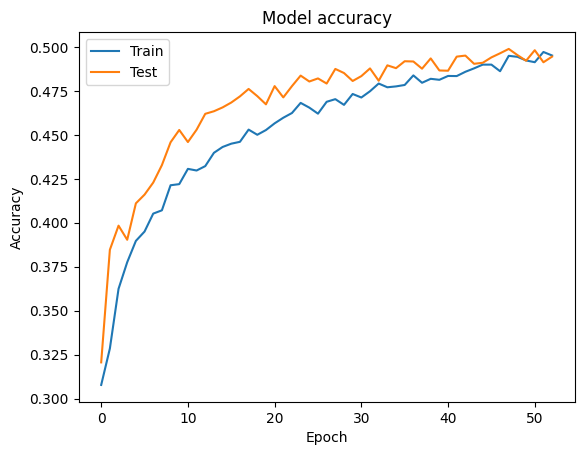

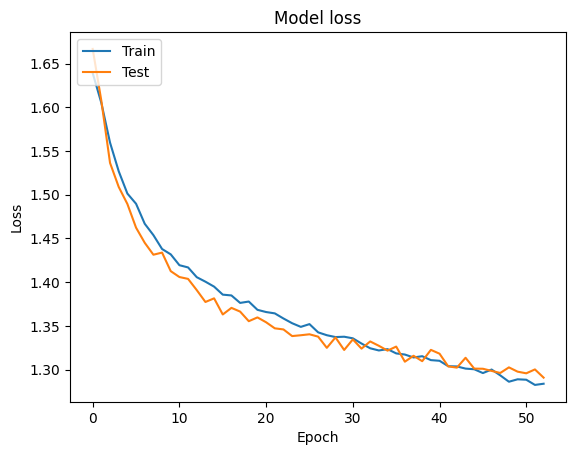

In [74]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [75]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_val, y_val)
print("Test accuracy: ", test_accuracy)


215/215 [==============================] - 2s 10ms/step - loss: 1.2961 - accuracy: 0.4988
Test accuracy:  0.49883347749710083


In [76]:
model.save('../Recognition/Model/FLD_FER_v1.keras')

: 